In [24]:
import torch

from models.predictionnet import ResBlock, UpSample, DownSample, AttentionBlock, DownBlock, UpBlock, MidBlock, PadBlock, UnPadBlock, UNet, DummyModel, PredictionModel
from models.latent_umbrella_net import LatentUmbrellaNet
from models.autoencoder import Autoencoder
from data.latents import LatentsDataModule
from models.blocks.distributions import DiagonalGaussianDistribution
from metrics.metrics import WeightedRMSE
from data.era5 import gen_bgen

from matplotlib import pyplot as plt

import xarray as xr
import numpy as np
import dask.array as da
import pandas as pd
import xbatcher as xb
import time
from tqdm import tqdm
from multiprocessing.dummy import Pool as ThreadPool
import yaml
import os

In [2]:
bgen = gen_bgen(train=True)

In [3]:
x_1_raw, x_2_raw, y_raw = bgen[0], bgen[6], bgen[12]
x_1_raw

<xarray.Dataset> Size: 287MB
Dimensions:                  (time: 1, latitude: 721, longitude: 1440, level: 13)
Coordinates:
  * latitude                 (latitude) float32 3kB 90.0 89.75 ... -89.75 -90.0
  * level                    (level) int64 104B 50 100 150 200 ... 850 925 1000
  * longitude                (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * time                     (time) datetime64[ns] 8B 1940-01-01
Data variables:
    2m_temperature           (time, latitude, longitude) float32 4MB 249.5 .....
    10m_u_component_of_wind  (time, latitude, longitude) float32 4MB -0.05452...
    10m_v_component_of_wind  (time, latitude, longitude) float32 4MB 6.86 ......
    mean_sea_level_pressure  (time, latitude, longitude) float32 4MB 1.042e+0...
    temperature              (time, level, latitude, longitude) float32 54MB ...
    u_component_of_wind      (time, level, latitude, longitude) float32 54MB ...
    v_component_of_wind      (time, level, latitude, longitude) float32 54MB ...
    geopotential             (time, level, latitude, longitude) float32 54MB ...
    specific_humidity        (time, level, latitude, longitude) float32 54MB ...
Attributes:
    last_updated:           2025-04-28 02:15:49.526994+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-01-31
    valid_time_stop_era5t:  2025-04-22

In [4]:
x_1_stacked = x_1_raw.to_stacked_array(
            new_dim="channel",
            sample_dims=["latitude", "longitude"]
        ).transpose("channel", "longitude", "latitude")

x_2_stacked = x_2_raw.to_stacked_array(
            new_dim="channel",
            sample_dims=["latitude", "longitude"]
        ).transpose("channel", "longitude", "latitude")

y_stacked = y_raw.to_stacked_array(
            new_dim="channel",
            sample_dims=["latitude", "longitude"]
        ).transpose("channel", "longitude", "latitude")

x_1_stacked

<xarray.DataArray '2m_temperature' (channel: 69, longitude: 1440, latitude: 721)> Size: 287MB
array([[[ 2.4950555e+02,  2.4945015e+02,  2.4943452e+02, ...,
          2.4237231e+02,  2.4212370e+02,  2.4175717e+02],
        [ 2.4950555e+02,  2.4945157e+02,  2.4943594e+02, ...,
          2.4237375e+02,  2.4212654e+02,  2.4175717e+02],
        [ 2.4950555e+02,  2.4945157e+02,  2.4943878e+02, ...,
          2.4237375e+02,  2.4212654e+02,  2.4175717e+02],
        ...,
        [ 2.4950555e+02,  2.4944873e+02,  2.4943311e+02, ...,
          2.4236948e+02,  2.4212370e+02,  2.4175717e+02],
        [ 2.4950555e+02,  2.4945015e+02,  2.4943311e+02, ...,
          2.4237231e+02,  2.4212370e+02,  2.4175717e+02],
        [ 2.4950555e+02,  2.4945015e+02,  2.4943311e+02, ...,
          2.4237231e+02,  2.4212370e+02,  2.4175717e+02]],

       [[-5.4524302e-02, -3.3171127e+00, -2.9565573e+00, ...,
         -3.8745196e+00, -3.8697841e+00,  2.3990126e+00],
        [-5.4524302e-02, -3.3286126e+00, -2.9714394e+00, ...,
         -3.8718135e+00, -3.8670785e+00,  2.3990126e+00],
        [-5.4524302e-02, -3.3407891e+00, -2.9910569e+00, ...,
         -3.8677547e+00, -3.8650491e+00,  2.3990126e+00],
...
          2.7475134e-04,  2.7140882e-04,  2.6624277e-04],
        [ 1.2829155e-04,  2.3129955e-04,  6.1993394e-04, ...,
          2.7475134e-04,  2.7140882e-04,  2.6624277e-04],
        [ 1.2829155e-04,  2.3129955e-04,  6.2054116e-04, ...,
          2.7475134e-04,  2.7140882e-04,  2.6624277e-04]],

       [[ 3.8897246e-04,  4.3792371e-04,  4.5566354e-04, ...,
          2.7497113e-04,  2.7168635e-04,  2.6642997e-04],
        [ 3.8897246e-04,  4.3792371e-04,  4.5566354e-04, ...,
          2.7497113e-04,  2.7168635e-04,  2.6642997e-04],
        [ 3.8897246e-04,  4.3792371e-04,  4.5566354e-04, ...,
          2.7497113e-04,  2.7168635e-04,  2.6642997e-04],
        ...,
        [ 3.8897246e-04,  4.3792371e-04,  4.5566354e-04, ...,
          2.7497113e-04,  2.7168635e-04,  2.6642997e-04],
        [ 3.8897246e-04,  4.3792371e-04,  4.5566354e-04, ...,
          2.7497113e-04,  2.7168635e-04,  2.6642997e-04],
        [ 3.8897246e-04,  4.3792371e-04,  4.5566354e-04, ...,
          2.7497113e-04,  2.7168635e-04,  2.6642997e-04]]],
      shape=(69, 1440, 721), dtype=float32)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * channel    (channel) object 552B MultiIndex
  * variable   (channel) <U23 6kB '2m_temperature' ... 'specific_humidity'
  * time       (channel) datetime64[ns] 552B 1940-01-01 ... 1940-01-01
  * level      (channel) object 552B nan nan nan nan 50 ... 600 700 850 925 1000
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

In [28]:
x_1 = torch.tensor(x_1_stacked.data).unsqueeze(0)
x_2 = torch.tensor(x_2_stacked.data).unsqueeze(0)
y = torch.tensor(y_stacked.data).unsqueeze(0)
y = y[:, :, :, :-1]

print(x_1.shape, x_2.shape, y.shape)

torch.Size([1, 69, 1440, 721]) torch.Size([1, 69, 1440, 721]) torch.Size([1, 69, 1440, 720])


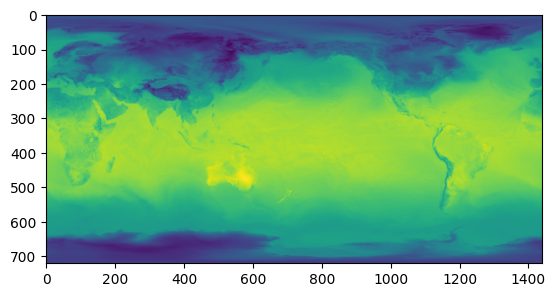

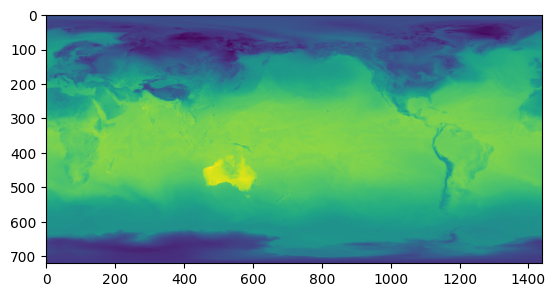

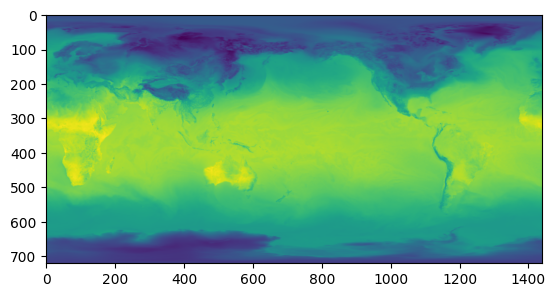

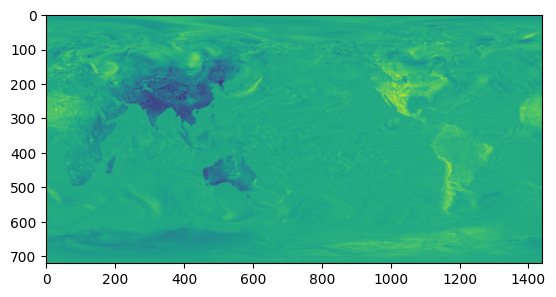

In [7]:
plt.imshow(x_1[0, 0].numpy().T)
plt.show()

plt.imshow(x_2[0, 0].numpy().T)
plt.show()

plt.imshow(y[0, 0].numpy().T)
plt.show()

dif = x_1 - x_2

plt.imshow(dif[0, 0].numpy().T)
plt.show()

In [10]:
lun = LatentUmbrellaNet(
    vae_ckpt_path="checkpoints/vae-kl-f8-rmse-disc-2-step=5000-z500=93.ckpt",
    vae_config_path="configs/autoencoder/kl-f8-disc.yaml",
    prediction_net_ckpt_path="lightning_logs/version_39/checkpoints/epoch=9-step=7200.ckpt",
    device="cuda",
)

c:\Users\hendr\Desktop\3d-vae\venv\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1, which is newer than your current Lightning version: v2.5.0.post0


In [11]:
pred = lun.forward(x_1, x_2)

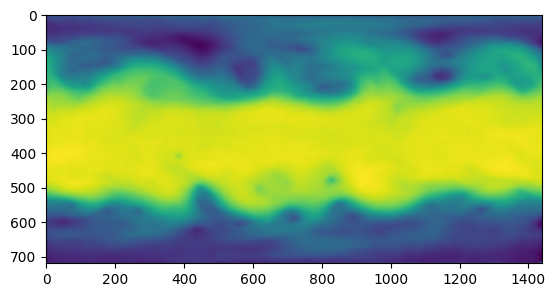

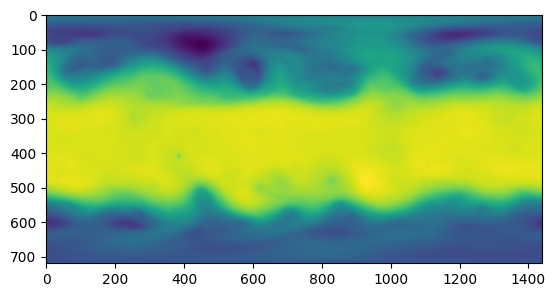

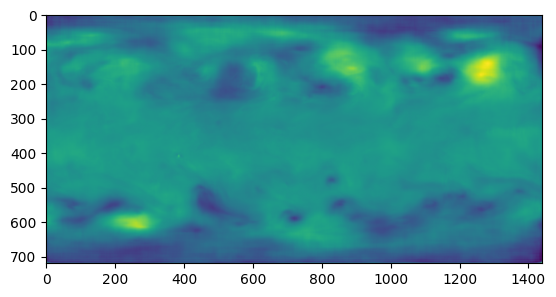

In [40]:
plt.imshow(pred[0, 50].numpy().T)
plt.show()

plt.imshow(y[0, 50].numpy().T)
plt.show()

plt.imshow(pred[0, 50].numpy().T - y[0, 50].numpy().T)
plt.show()

In [44]:
wrmse = WeightedRMSE(num_latitudes=720)
error = wrmse(pred.numpy(), y.numpy())
print(error[0, 50])

483.64151160290214
